2024-07-17 00:39:01.534800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 00:39:01.542603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 00:39:01.550954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 00:39:01.553396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 00:39:01.560267: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


I0000 00:00:1721169542.684826   37052 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721169542.703727   37052 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721169542.703838   37052 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721169542.707325   37052 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

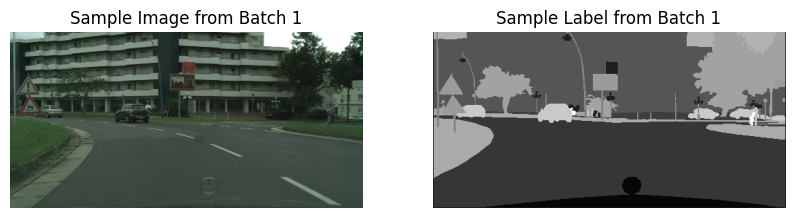

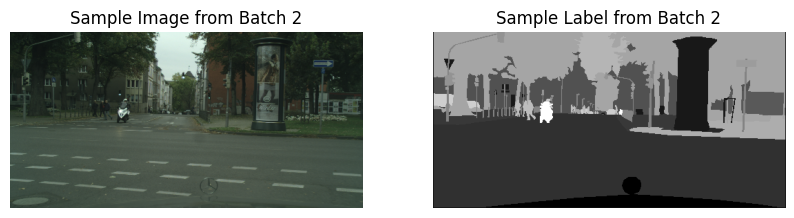

2024-07-17 00:39:03.271813: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

data_dir = '/home/maith/Desktop/cityscapes'
train_images_dir = os.path.join(data_dir, 'leftImg8bit/train')
train_labels_dir = os.path.join(data_dir, 'gtFine/train')

def preprocess_image(image_path, label_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.squeeze(label)
    return image, tf.cast(label, tf.int32)

def file_paths_generator():
    count = 0
    for city in sorted(os.listdir(train_images_dir)):
        city_images_path = os.path.join(train_images_dir, city)
        city_labels_path = os.path.join(train_labels_dir, city)
        for image_name in sorted(os.listdir(city_images_path)):
            if image_name.endswith('_leftImg8bit.png'):
                image_path = os.path.join(city_images_path, image_name)
                label_name = image_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                label_path = os.path.join(city_labels_path, label_name)
                count += 1
                yield image_path, label_path
    print(f'Total images processed: {count}')

def create_dataset():
    dataset = tf.data.Dataset.from_generator(
        generator=file_paths_generator,
        output_types=(tf.string, tf.string),
        output_shapes=((), ()))

    dataset = dataset.map(lambda x, y: preprocess_image(x, y))
    return dataset.repeat()

dataset = create_dataset().batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

try:
    for batch, (images, labels) in enumerate(dataset.take(2)):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f'Sample Image from Batch {batch+1}')
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'Sample Label from Batch {batch+1}')
        plt.imshow(labels[0].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()
except tf.errors.OutOfRangeError:
    print("Attempted to access beyond the available data.")

In [2]:
import os
import numpy as np
import tensorflow as tf

data_dir = '/home/maith/Desktop/cityscapes'
train_labels_dir = os.path.join(data_dir, 'gtFine/train')

def analyze_dataset(train_labels_dir):
    class_ids = []
    for city in sorted(os.listdir(train_labels_dir)):
        city_labels_path = os.path.join(train_labels_dir, city)
        for label_file in sorted(os.listdir(city_labels_path)):
            if label_file.endswith('_labelIds.png'):
                label_path = os.path.join(city_labels_path, label_file)
                label = tf.io.read_file(label_path)
                label = tf.image.decode_png(label, channels=1)
                unique_ids = np.unique(label.numpy())
                class_ids.extend(unique_ids)
    
    unique_class_ids = np.unique(class_ids)
    return unique_class_ids

# Get unique class IDs
unique_class_ids = analyze_dataset(train_labels_dir)
print(f"Unique class IDs in the dataset: {unique_class_ids}")
print(f"Total number of classes: {len(unique_class_ids)}")

Unique class IDs in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Total number of classes: 34


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_shape=(256, 512, 3), num_classes=34):
    inputs = Input(input_shape)
    
    # Downsample
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Upsample
    u1 = UpSampling2D((2, 2))(b)
    concat1 = concatenate([u1, c2])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    u2 = UpSampling2D((2, 2))(c3)
    concat2 = concatenate([u2, c1])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c4)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 256,  │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 256,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 512,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 512,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 512,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 512,  │      2,210 │ conv2d_4[0][0]    │
│                     │ 34)               │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 926,178 (3.53 MB)

 Trainable params: 926,178 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU

def compile_model(model):
    optimizer = Adam(learning_rate=0.001)
    loss = SparseCategoricalCrossentropy()
    metrics = ['accuracy', MeanIoU(num_classes=34)]

    model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

compile_model(model)

print("Model compiled successfully with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy & MeanIoU metrics.")

Model compiled successfully with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy & MeanIoU metrics.


In [5]:
import tensorflow as tf

def load_and_preprocess_image(image_path, label_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.squeeze(label, axis=-1)

    return image, label

def prepare_dataset(image_dir, label_dir, batch_size=8):
    image_paths = [os.path.join(image_dir, city, f) for city in os.listdir(image_dir) for f in os.listdir(os.path.join(image_dir, city)) if f.endswith('_leftImg8bit.png')]
    label_paths = [p.replace('_leftImg8bit.png', '_gtFine_labelIds.png').replace('leftImg8bit', 'gtFine') for p in image_paths]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_image_dir = os.path.join(data_dir, 'leftImg8bit/train')
train_label_dir = os.path.join(data_dir, 'gtFine/train')
val_image_dir = os.path.join(data_dir, 'leftImg8bit/val')
val_label_dir = os.path.join(data_dir, 'gtFine/val')

train_dataset = prepare_dataset(train_image_dir, train_label_dir)
val_dataset = prepare_dataset(val_image_dir, val_label_dir)

print("Training and validation datasets are ready.")

Training and validation datasets are ready.


In [6]:
def check_dataset_shapes(dataset):
    for images, labels in dataset.take(1):
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)

check_dataset_shapes(train_dataset)
check_dataset_shapes(val_dataset)

Images shape: (8, 256, 512, 3)
Labels shape: (8, 256, 512)
Images shape: (8, 256, 512, 3)
Labels shape: (8, 256, 512)


2024-07-17 00:39:49.952981: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
from tensorflow.keras.layers import Conv2D

def check_model_output(model, input_shape=(1, 256, 512, 3)):
    test_input = tf.random.normal(input_shape)
    test_output = model(test_input)
    print("Test output shape:", test_output.shape)

check_model_output(model)

2024-07-17 00:39:50.084680: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
W0000 00:00:1721169590.120742   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.150739   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.152125   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.152807   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.153497   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.206053   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.207712   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.209686   37052 gpu_t

Test output shape: (1, 256, 512, 34)


W0000 00:00:1721169590.608378   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.611471   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.614253   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.618248   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.622220   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.626190   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.630489   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.634537   37052 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721169590.638642   37052 gp

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    os.path.join('/home/maith/Desktop/cityscapes/', 'best_model.keras'), 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1
)

print("Training complete.")

Epoch 1/50


I0000 00:00:1721169631.665890   37206 service.cc:146] XLA service 0x7be6e0003580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721169631.665913   37206 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-07-17 00:40:31.725971: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1721169631.765860   37206 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-07-17 00:40:37.505119: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
202

  1/372 ━━━━━━━━━━━━━━━━━━━━ 2:34:50 25s/step - accuracy: 2.9659e-04 - loss: 18.7057

I0000 00:00:1721169655.808748   37206 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4367 - loss: 2.7246

W0000 00:00:1721169722.240347   37211 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-07-17 00:42:06.969848: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4369 - loss: 2.7225

W0000 00:00:1721169743.841706   37208 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1721169749.614127   37211 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 1.52534, saving model to /home/maith/Desktop/cityscapes/best_model.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 120s 256ms/step - accuracy: 0.4372 - loss: 2.7204 - val_accuracy: 0.6041 - val_loss: 1.5253
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6470 - loss: 1.3535
Epoch 2: val_loss improved from 1.52534 to 1.35859, saving model to /home/maith/Desktop/cityscapes/best_model.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - accuracy: 0.6470 - loss: 1.3534 - val_accuracy: 0.6442 - val_loss: 1.3586
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6781 - loss: 1.2059
Epoch 3: val_loss did not improve from 1.35859
372/372 ━━━━━━━━━━━━━━━━━━━━ 70s 189ms/step - accuracy: 0.6781 - loss: 1.2059 - val_accuracy: 0.5952 - val_loss: 1.4967
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6898 - loss: 1.1560
Epoch 4: val_loss improved from 1.35859 to 1.20580, saving model to /home/maith/Desktop/cityscapes/

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [ ]:
import numpy as np

true_labels = []
pred_labels = []

for images, labels in val_dataset:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=-1)
    true_labels.extend(labels.numpy().flatten())
    pred_labels.extend(preds.flatten())

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_class_ids, yticklabels=unique_class_ids)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()